## Loading the dataset

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
!unzip gdrive/MyDrive/Archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Pepper__bell___Bacterial_spot/33952a4a-ef41-4eff-9a2a-35bbea1b6686___JR_B.Spot 3200.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/ab10eb3c-cf6e-49bf-a220-2a7d3ffdb717___NREC_B.Spot 1961.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/1044c742-39a0-4b1a-984f-3cb2bdeda94b___NREC_B.Spot 9219.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/21f7119e-d926-4be3-9ace-d6b26b280e64___JR_B.Spot 8837.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/1219f26f-a23a-4c2a-99f0-407fc785c74a___JR_B.Spot 3332.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/9c23ddea-18e9-4b79-b890-77c6077d8966___JR_B.Spot 3195.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/6b1b260e-fab5-4a73-936c-5592119c13fe___NREC_B.Spot 1952.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/67e58468-8546-4324-8e1e-ae10abf2cb5b___JR_B.Spot 9099.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/bc76d04a-056a-4fa4-a3d

## Preparing training, testing and validating set

In [16]:
import os
import shutil
import random

In [17]:
# Define the paths to the train, test, and validation directories
root = os.getcwd()
train_dir = os.path.join(root, "train")
test_dir = os.path.join(root, "test")
val_dir = os.path.join(root, "val")

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
# Define the image data generators for each split
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# Define the batch size
batch_size = 32

# Define the input shape
input_shape = (224, 224, 3)

In [21]:
# Define the training, testing, and validation generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=input_shape[:2],
                                                  batch_size=batch_size,
                                                  class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 19850 images belonging to 15 classes.
Found 3914 images belonging to 15 classes.
Found 3971 images belonging to 15 classes.


## Training the VGG16 model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model

# Define the input shape
input_shape = (224, 224, 3)

# Load the VGG16 model
vgg16 = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

# Freeze the layers in the VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

# Add new layers on top of the VGG16 model
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(15, activation='softmax')(x)

# Create a new model
model = Model(inputs=vgg16.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
epochs = 30
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

In [ ]:
# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps)

# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Saving the model
model.save('vgg16_model.h5')

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
620/620 [==============================] - 284s 439ms/step - loss: 0.7398 - accuracy: 0.7624 - val_loss: 0.4108 - val_accuracy: 0.8629
Epoch 2/30
620/620 [==============================] - 263s 424ms/step - loss: 0.4051 - accuracy: 0.8623 - val_loss: 0.4344 - val_accuracy: 0.8508
Epoch 3/30
620/620 [==============================] - 263s 423ms/step - loss: 0.3278 - accuracy: 0.8874 - val_loss: 0.2996 - val_accuracy: 0.9005
Epoch 4/30
620/620 [==============================] - 266s 430ms/step - loss: 0.2792 - accuracy: 0.9024 - val_loss: 0.5027 - val_accuracy: 0.8511
Epoch 5/30
620/620 [==============================] - 269s 434ms/step - loss: 0.2545 - accuracy: 0.9125 - val_loss: 0.3475 - val_accuracy: 0.8891
Epoch 6/30
620/620 [==============================] - 265s 428ms/step - loss: 0.2191 - accuracy: 0.9240 - val_loss: 0.1816 - val_accuracy: 0.9385
Epoch 7/30
620/620 [==============================] - 262s 

## Fine tuning the model to increase the accuracy

In [ ]:
# Unfreeze the top layers of the VGG16 model
for layer in vgg16.layers[-4:]:
    layer.trainable = True

# Lower the learning rate
from keras.optimizers import SGD
opt = SGD(lr=0.0001)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model again
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Save the fine-tuned model
model.save('vgg16_fine_tuned_model.h5')


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
620/620 [==============================] - 285s 440ms/step - loss: 0.0450 - accuracy: 0.9837 - val_loss: 0.0739 - val_accuracy: 0.9758
Epoch 2/30
620/620 [==============================] - 273s 441ms/step - loss: 0.0403 - accuracy: 0.9856 - val_loss: 0.0684 - val_accuracy: 0.9773
Epoch 3/30
620/620 [==============================] - 270s 435ms/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.0638 - val_accuracy: 0.9788
Epoch 4/30
620/620 [==============================] - 274s 442ms/step - loss: 0.0363 - accuracy: 0.9869 - val_loss: 0.0609 - val_accuracy: 0.9793
Epoch 5/30
620/620 [==============================] - 273s 441ms/step - loss: 0.0345 - accuracy: 0.9880 - val_loss: 0.0587 - val_accuracy: 0.9798
Epoch 6/30
620/620 [==============================] - 270s 436ms/step - loss: 0.0316 - accuracy: 0.9884 - val_loss: 0.0575 - val_accuracy: 0.9796
Epoch 7/30
620/620 [==============================] - 272s 438ms/step - loss: 0.0318 - accuracy: 0.9898 - val_loss: 0.0568 -

## Sample Prediction

In [2]:
!unzip gdrive/MyDrive/vgg16_models.zip

Archive:  gdrive/MyDrive/vgg16_models.zip
  inflating: vgg16_fine_tuned_model.h5  
  inflating: vgg16_model.h5          


In [4]:
# loading the saved model
from keras.models import load_model
model = load_model('vgg16_fine_tuned_model.h5')

In [6]:
from keras.utils import load_img, img_to_array
import numpy as np
from keras.applications.vgg16 import preprocess_input

In [29]:
class_indices = train_generator.class_indices

# Invert the dictionary using a dictionary comprehension
class_names = {v: k for k, v in class_indices.items()}

In [30]:
class_names

{0: 'Pepper__bell___Bacterial_spot',
 1: 'Pepper__bell___healthy',
 2: 'Potato___Early_blight',
 3: 'Potato___Late_blight',
 4: 'Potato___healthy',
 5: 'Tomato_Bacterial_spot',
 6: 'Tomato_Early_blight',
 7: 'Tomato_Late_blight',
 8: 'Tomato_Leaf_Mold',
 9: 'Tomato_Septoria_leaf_spot',
 10: 'Tomato_Spider_mites_Two_spotted_spider_mite',
 11: 'Tomato__Target_Spot',
 12: 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 13: 'Tomato__Tomato_mosaic_virus',
 14: 'Tomato_healthy'}

In [7]:
class_names = {
 0: 'Pepper__bell___Bacterial_spot',
 1: 'Pepper__bell___healthy',
 2: 'Potato___Early_blight',
 3: 'Potato___Late_blight',
 4: 'Potato___healthy',
 5: 'Tomato_Bacterial_spot',
 6: 'Tomato_Early_blight',
 7: 'Tomato_Late_blight',
 8: 'Tomato_Leaf_Mold',
 9: 'Tomato_Septoria_leaf_spot',
 10: 'Tomato_Spider_mites_Two_spotted_spider_mite',
 11: 'Tomato__Target_Spot',
 12: 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 13: 'Tomato__Tomato_mosaic_virus',
 14: 'Tomato_healthy'}

In [57]:
img_path = 'test_img.JPG'

1/1 [==============================] - 1s 557ms/step


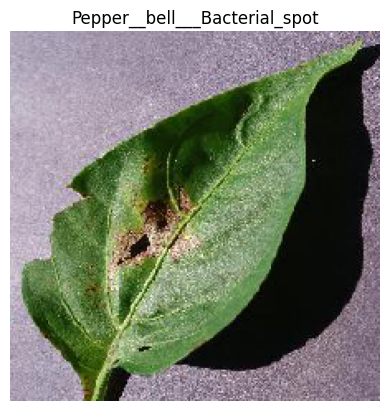

In [58]:
# Load a sample image
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x /= 255.
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# Make a prediction
preds = model.predict(x)
class_idx = np.argmax(preds[0])
predicted_label = class_names[class_idx]
# print(class_idx)

# Display the image and prediction
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)
plt.show()